In [1]:
!pip install --quiet duckdb
# !pip install --quiet jupysql 
# !pip install --quiet duckdb-engine
!pip install --quiet chart-studio
!pip install --quiet pycaret 
!pip install --quiet pandas_profiling
!pip install --quiet dython
!pip install --quiet numpy  --upgrade --user
!pip install --quiet dowhy  --upgrade --user

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 2023.621.222118 requires jupyter-server~=1.16, but you have jupyter-server 2.6.0 which is incompatible.
fitter 1.6.0 requires pandas<3.0.0,>=2.0.3, but you have pandas 1.5.3 which is incompatible.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.10.1 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0

In [3]:
import warnings
warnings.simplefilter("ignore")

# data engineering
import duckdb
# Import jupysql Jupyter extension to create SQL cells
%load_ext sql

# data processing, compute, auto-EDA
import numpy as np
import scipy
from scipy import stats
from datetime import datetime
import pandas as pd 
from pandas_profiling import ProfileReport

# visualizations for EDA
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# import chart_studio.plotly as py
# import plotly.graph_objs as go
# import cufflinks as cf
# from plotly import figure_factory as FF
# from plotly.offline import iplot
# cf.go_offline() #will make cufflinks offline
# cf.set_config_file(offline=False, world_readable=True)

# correlation scores
from sklearn.metrics import jaccard_score
from dython.nominal import associations
from dython.nominal import identify_nominal_columns

# feature importance
from pycaret.classification import *
from pycaret.regression import *

# causality inference
from dowhy import CausalModel

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


# Objective: 
### Predict estimated delivery time in seconds.
(from created_at to actual_delivery_time)

# The Data

#### Data description #### 
The attached file `historical_data.csv` contains a subset of deliveries received at DoorDash in early 2015 in a subset of the cities. Each row in this file corresponds to one unique delivery. Each column corresponds to a feature as explained below. Note all money (dollar) values given in the data are in cents and all time duration values given are in seconds. 
The target value to predict here is the total seconds value between `created_at` and `actual_delivery_time`. 

We have added noise to the dataset to obfuscate certain business details. Both `historical_data.csv` and `data_to_predict.json` include similar noise. We will only be evaluating your model's performance on this noisy, artificial dataset. The baseline model we will compare it was also trained and evaluated on the same noisy dataset.

#### Columns in historical_data.csv

### Time features
* market_id: A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id
* created_at: Timestamp in UTC when the order was submitted by the consumer to DoorDash. (Note this timestamp is in UTC, but in case you need it, the actual timezone of the region was US/Pacific)
* actual_delivery_time: Timestamp in UTC when the order was delivered to the consumer

### Store features 
* store_id: an id representing the restaurant the order was submitted for
* store_primary_category: cuisine category of the restaurant, e.g., italian, asian
* order_protocol: a store can receive orders from DoorDash through many modes. This field represents an id denoting the protocol

### Order features
* total_items: total number of items in the order
* subtotal: total value of the order submitted (in cents)
* num_distinct_items: number of distinct items included in the order
* min_item_price: price of the item with the least cost in the order (in cents)
* max_item_price: price of the item with the highest cost in the order (in cents)

### Market features
DoorDash being a marketplace, we have information on the state of marketplace when the order is placed, that can be used to estimate delivery time. The following features are values at the time of * *`created_at` (order submission time)
* total_onshift_dashers: Number of available dashers who are within 10 miles of the store at the time of order creation 
* total_busy_dashers: Subset of above `total_onshift_dashers` who are currently working on an order
* total_outstanding_orders: Number of orders within 10 miles of this order that are currently being processed.

### Predictions from other models:
We have predictions from other models for various stages of delivery process that we can use.
* estimated_order_place_duration: Estimated time for the restaurant to receive the order from DoorDash (in seconds)
* estimated_store_to_consumer_driving_duration: Estimated travel time between store and consumer (in seconds)



#####################################################################################
#### Data to predict #### 
Also attached here is `data_to_predict.json`, which provides the new data that you must predict on using the model you build. This data was generated similar to the `historical_data.csv` and it contains the same columns as above, except for the following differences:
  * This file does not contain `actual_delivery_time`, since that is unknown at the time of prediction
  * This file contains `delivery_id` as additional field
  * This file may contain other additional fields
Each row of the data is one data point to predict on. Note that `data_to_predict.json` contains orders from later weeks compared to `historical_data` 

In [4]:
data = pd.read_csv('/kaggle/input/doordash-takehome/historical_data.csv')
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


# Exploratory Data Analysis

# Need to categorize columns into data types:

* numerical 
    * (non-discrete)/continuous 
        * subtotal
        * min_item_price
        * max_item_price
    * (discrete) 
        * total_items
        * num_distinct_items
        * total_onshift_dashers
        * total_busy_dashers
        * total_outstanding_orders
        * estimated_order_place_duration
        * estimated_store_to_consumer_driving_duration 
* categorical 
    * binary (0/1)
    * multiple types (movie genres)
        * market_id
        * store_id
        * store_primary_category
        * order_protocol
    * ordinal
        * created_at
        * actual_delivery_time
    * survey numbers (rank)
* no time series

Based on data type, determines types of graphs used to explore data.

## Univariate analysis 
- mostly to see if there are outliers

In [5]:
# How many distinct deliveries
len(data)

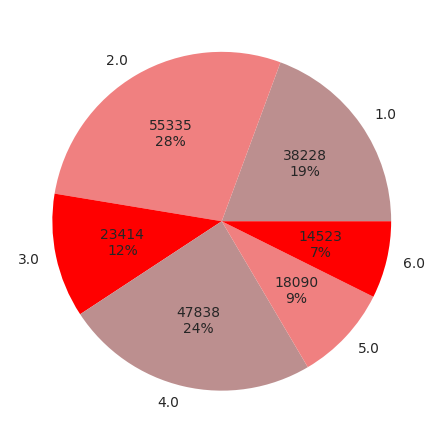

In [6]:
# Different markets' proportion in sample data

def label_function(val):
    return f'{val / 100 * len(data):.0f}\n{val:.0f}%'

data.groupby('market_id').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 10},
                                  colors=['rosybrown', 'lightcoral', 'red'])
plt.show()

Markets 2, 4 and 1 have the highest proportion of deliveries.

In [7]:
# Data Time Frame
query = """
select min(created_at)
, max(created_at)
, cast(max(created_at) as timestamp) - cast(min(created_at) as timestamp)
from data
"""

duckdb.query(query).df()

,min(created_at),max(created_at),(CAST(max(created_at) AS TIMESTAMP) - CAST(min(created_at) AS TIMESTAMP))
0,2014-10-19 05:24:15,2015-02-18 06:00:44,122 days 00:36:29


~ 4 months of delivery activity

In [8]:
query = """
select store_id as restaurant
, count(*) as counts
from data
group by 1
order by 2 desc
"""

duckdb.query(query).df()

,restaurant,counts
0,6865,937
1,1311,863
2,314,815
3,1686,765
4,3937,721
...,...,...
6738,5473,1
6739,4398,1
6740,4822,1
6741,5474,1


In [9]:
query = """
select count(distinct store_id) as unique_restaurants
from data
"""

duckdb.query(query).df() 

,unique_restaurants
0,6743


In [10]:
query = """
select 
count(distinct store_primary_category) as unique_restaurant_categories
from data
"""

duckdb.query(query).df() 

,unique_restaurant_categories
0,74


In [11]:
query = """
select store_primary_category 
, count(*) as count
from data
group by 1
order by 2 desc
"""

duckdb.query(query).df()[:20] #Mostly American

,store_primary_category,count
0,american,19399
1,pizza,17321
2,mexican,17099
3,burger,10958
4,sandwich,10060
5,chinese,9421
6,japanese,9196
7,dessert,8773
8,fast,7372
9,indian,7314


In [12]:
query = """
select order_protocol
, count(*) as count
from data
group by 1
order by 2 desc
"""

opc = duckdb.query(query).df()
opc

,order_protocol,count
0,1.0,54725
1,3.0,53199
2,5.0,44290
3,2.0,24052
4,4.0,19354
5,NaN,995
6,6.0,794
7,7.0,19


<Axes: xlabel='order_protocol'>

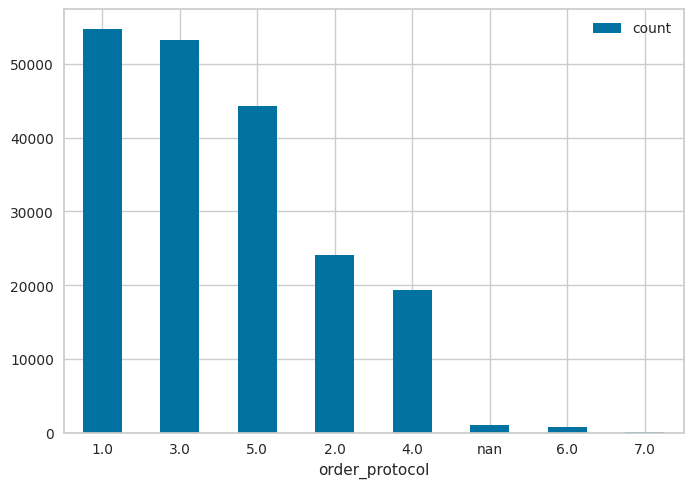

In [13]:
opc.plot.bar(x='order_protocol', y='count', rot=0)

<Axes: >

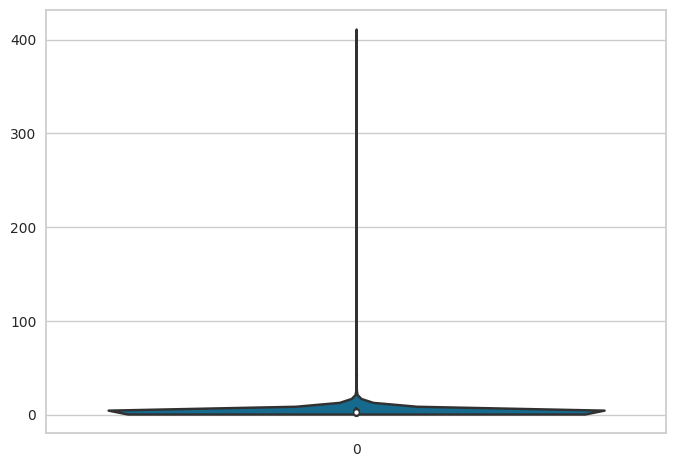

In [14]:
sns.violinplot(data=data['total_items'])

In [15]:
data.total_items.describe() #Median is at 3 items/delivery; 411 items must be for catered order

count    197428.000000
mean          3.196391
std           2.666546
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max         411.000000
Name: total_items, dtype: float64

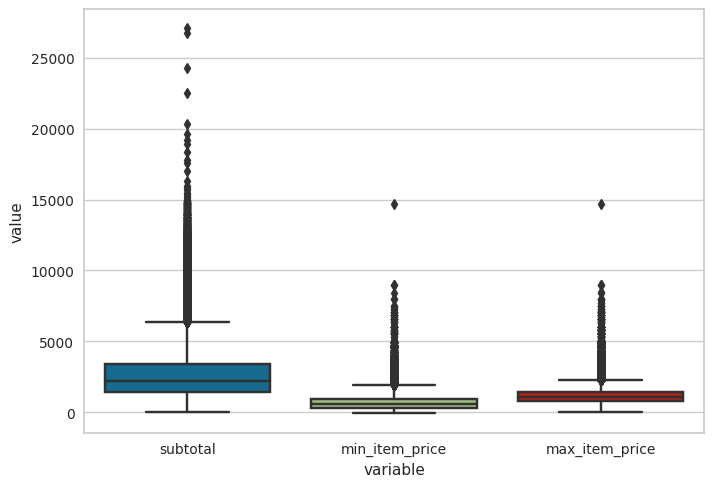

In [20]:
sns.boxplot(x="variable", y="value", data=pd.melt(data[['subtotal', 'min_item_price', 'max_item_price']]))
plt.show()

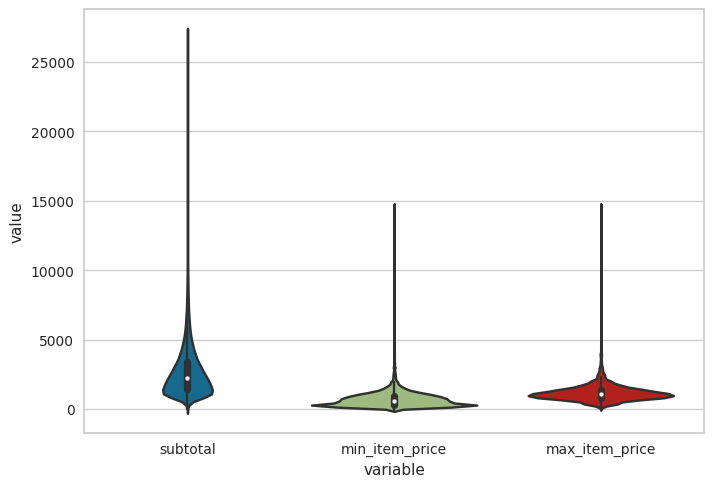

In [19]:
sns.violinplot(x="variable", y="value", data=pd.melt(data[['subtotal', 'min_item_price', 'max_item_price']]))
plt.show()

Most outliers in subtotal

In [24]:
# Many outliers again
subtotal_dol = data['subtotal']/100
subtotal_dol.describe() # Most orders are $33 and under; %271 is catered

count    197428.000000
mean         26.823314
std          18.230937
min           0.000000
25%          14.000000
50%          22.000000
75%          33.950000
max         271.000000
Name: subtotal, dtype: float64

<Axes: xlabel='variable', ylabel='value'>

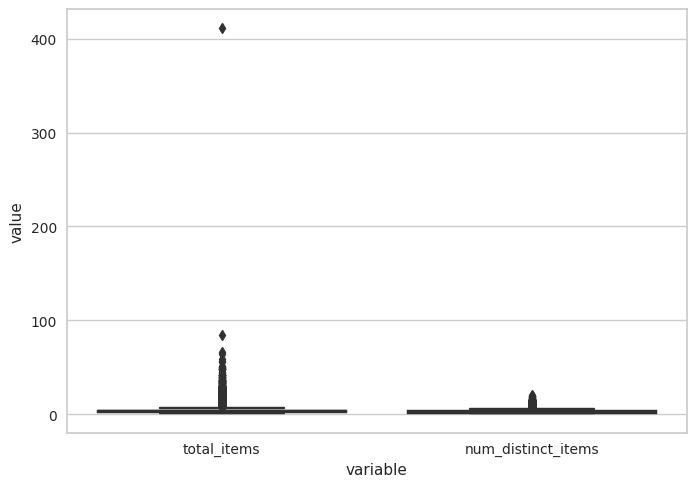

In [27]:
sns.boxplot(x="variable", y="value", data=pd.melt(data[['total_items', 'num_distinct_items']]))

Outlier in total_items. Let's see in detail with quartile distribution.

In [28]:
data.total_items.describe()

count    197428.000000
mean          3.196391
std           2.666546
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max         411.000000
Name: total_items, dtype: float64

In [29]:
# Let's take out and see what distribution is without it
query = """
select *
from data
where total_items != 411
"""

data2 = duckdb.query(query).df()

<Axes: xlabel='variable', ylabel='value'>

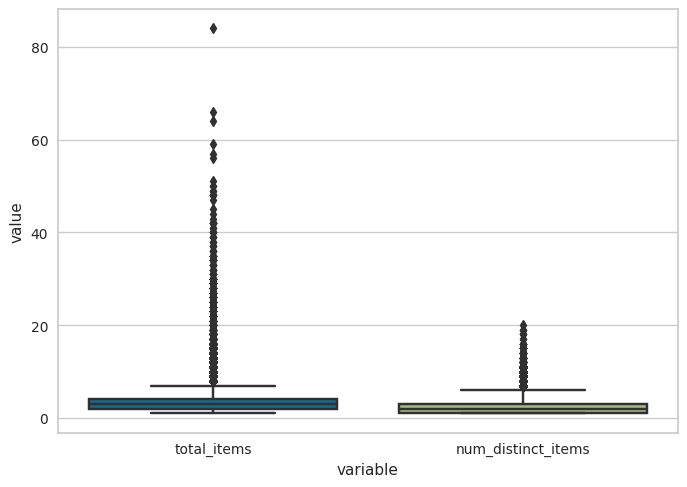

In [41]:
sns.boxplot(x="variable", y="value", data=pd.melt(data2[['total_items', 'num_distinct_items']]))

<Axes: xlabel='variable', ylabel='value'>

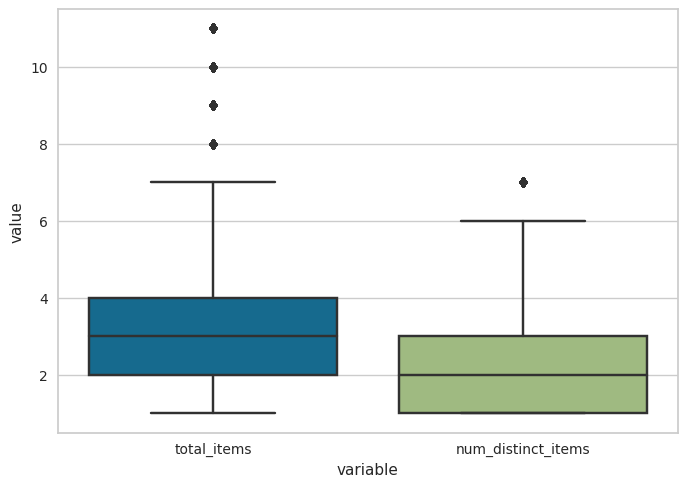

In [34]:
#Let's see what the meat of the data is by using z-score to eliminate any data outside of 3 standard deviations from mean
data3 = data[(np.abs(stats.zscore(data[['total_items', 'num_distinct_items']])) < 3).all(axis=1)]
sns.boxplot(x="variable", y="value", data=pd.melt(data3[['total_items', 'num_distinct_items']]))

Much cleaner. We see that majority of total items per delivery is 3 with 2 unique items.

<Axes: xlabel='variable', ylabel='value'>

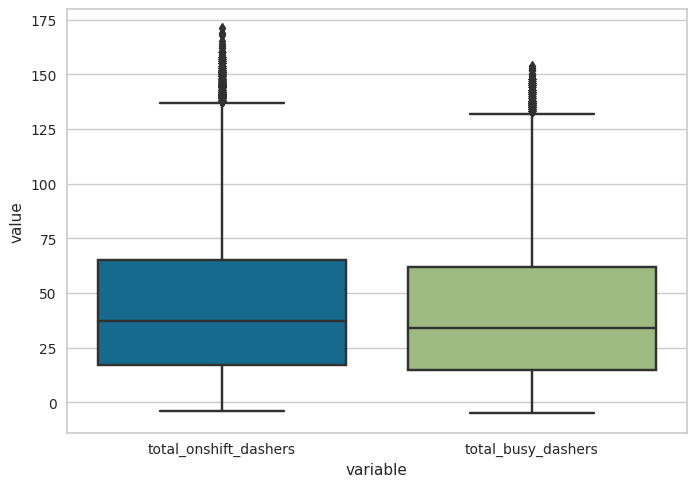

In [35]:
sns.boxplot(x="variable", y="value", data=pd.melt(data[['total_onshift_dashers', 'total_busy_dashers']]))

Looks like there is a good amount of overlap, with more variability with total onshift dashers. Some may be just loggin in on the app.

<Axes: xlabel='dash_coverage'>

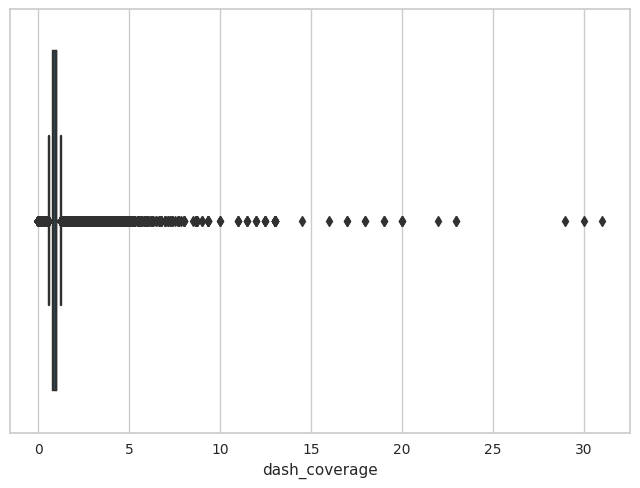

In [38]:
#Best to do a ratio to get coverage/check in on idleness

query = """
select *
, total_busy_dashers/total_onshift_dashers as dash_coverage
from data
where total_onshift_dashers >=0
and total_busy_dashers >= 0
"""

data4 = duckdb.query(query).df()
sns.boxplot(x=data4["dash_coverage"])

In [39]:
data4["dash_coverage"].describe()

count    177513.000000
mean          0.950438
std           0.401563
min           0.000000
25%           0.826923
50%           0.962264
75%           1.000000
max          31.000000
Name: dash_coverage, dtype: float64

75% of the data has 100% coverage. Need to check DoorDash's internal metrics to see what is their baseline success for this metric.

<Axes: xlabel='total_outstanding_orders'>

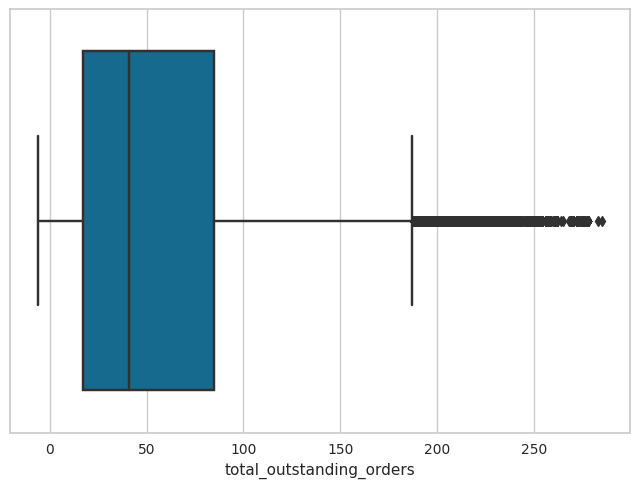

In [42]:
sns.boxplot(x=data["total_outstanding_orders"])

<Axes: xlabel='variable', ylabel='value'>

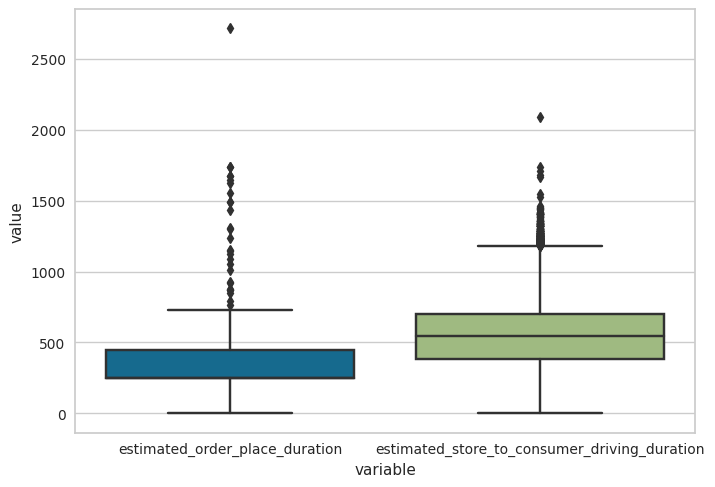

In [43]:
sns.boxplot(x="variable", y="value", data=pd.melt(data[['estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration']]))

# Feature Engineering

# Model Evaluation

# Use Picked Model to make Predictions using json file